In [1]:
!pip install pyroomacoustics
!pip install matplotlib


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from scipy.io import wavfile
import os
from pyroomacoustics import utilities


C:\Users\marek\AppData\Local\Temp\ipykernel_14844\69737811.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio = wavfile.read(os.path.join("sound_files", "spacebell.wav"))


The desired RT60 was 0.3
The measured RT60 is 0.00033333333333333305


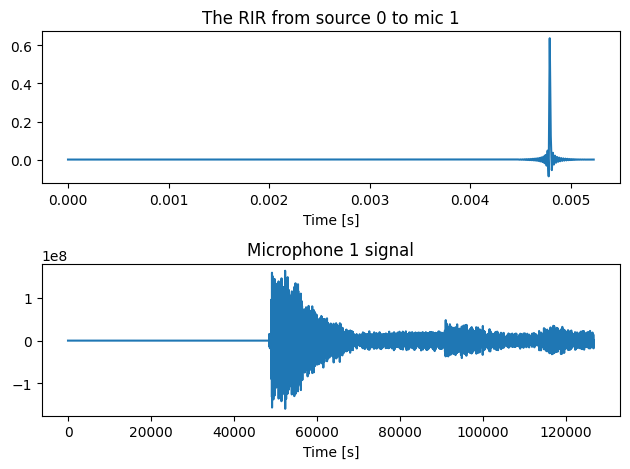

In [239]:
# The desired reverberation time and dimensions of the room
rt60_tgt = 0.3  # seconds
room_dim = [2, 3, 2.5]  # meters

# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
fs, audio = wavfile.read(os.path.join("sound_files", "spacebell.wav"))

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

room=None

# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=0
)

audio = np.array(audio)[:, 0]

# place the source in the room
room.add_source([1, 1.2, 1.76], signal=audio, delay=0.5)

# define the locations of the microphones
mic_locs = np.c_[
    [1.5, 1.5, 1.2], [0.5, 2.5, 1.2],  # mic 1  # mic 2
]

# finally place the array in the room
room.add_microphone_array(mic_locs)

# Run the simulation (this will also build the RIR automatically)
room.simulate()

room.mic_array.to_wav(
    f"bell_16k_reverb.wav",
    norm=True,
    bitdepth=np.int16,
)

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {}".format(rt60_tgt))
print("The measured RT60 is {}".format(rt60[1, 0]))

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[1][0]
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 1")
plt.xlabel("Time [s]")

# plot signal at microphone 1
plt.subplot(2, 1, 2)
plt.plot(room.mic_array.signals[1, :])
plt.title("Microphone 1 signal")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

In [240]:
def standard_line_form_from_parameterized(ray, support_vector):

    # [[x], [y]] = t * ray + support_vector, t e R
    # Ax + By = C
    A =  -ray[1] #- slope
    B = ray[0]  # 1
    C = ray[0]*support_vector[1] - ray[1] * support_vector[0]  # support_vector[1] - slope * support_vector[0]

    return [A, B, C]

In [241]:
def get_decision_boundary(p1, p2, ild):
  rot_mat = np.array([[math.cos(math.pi/2), math.sin(ild *math.pi/2)],
                      [-math.sin(ild * math.pi/2), math.cos(math.pi/2)]])

  return rot_mat @ (p1 - p2), (p1 - p2) / 2 + p2

In [474]:
def ILD(db_2, db_1):
  return 1 if db_1 >= db_2 else -1

# microphones: [{pos: np.array([x,y]), average_db: db} ...]
def determine_sound_source_halfspaces(microphones):

    separations = []

    for i in range(int(len(microphones)/3)):

        microphone_group = microphones[i*3: (i+1)*3]

        pairs = [(1, 0), (0, 2), (1, 2)]
        for pair in pairs:
            
            main_microphone = microphone_group[pair[0]]
            compared_microphone = microphone_group[pair[1]]
            
            direction = ILD(main_microphone["dB"], compared_microphone["dB"])

            #print("Pair {} with decision {}: main {} with dB {}; compared {} with dB {}".format(pair, direction,
            #                                                                                    pair[0], main_microphone["dB"],
            #                                                                                    pair[1], compared_microphone["dB"]))
            ray, support_vector = get_decision_boundary(main_microphone["pos"],
                                                        compared_microphone["pos"],
                                                        direction)
            std_separation = standard_line_form_from_parameterized(ray, support_vector)
            separations.append({"std_form": std_separation, "parameterized": (ray, support_vector, direction)})

    return separations

def aggregate_separations_to_simplex(separations):

    A = np.zeros((len(separations), 2))
    b = np.zeros((len(separations), 1))

    for i, separation in enumerate(separations):

        A_sep, B_sep, C_sep = separation["std_form"]
        A[i, 0] = A_sep
        A[i, 1] = B_sep
        b[i] = C_sep

    return A, b

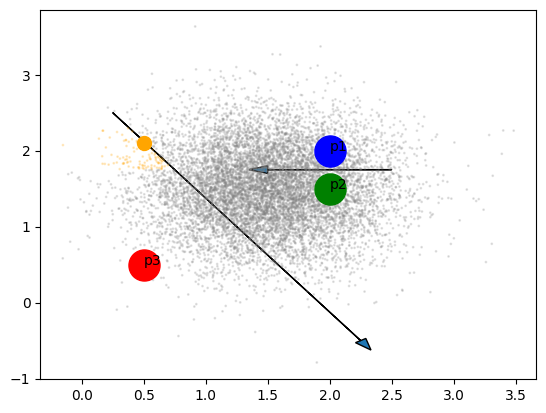

In [475]:
import matplotlib.pyplot as plt

p1 = np.array([2, 2])
p2 = np.array([2, 1.5])

p3 = np.array([0.5, 0.5])

sound_loc = np.array([0.5, 2.1])

def sim_ILD(p1, p2, sound_loc):

    if np.linalg.norm(sound_loc-p1) > np.linalg.norm(sound_loc-p2) :
        return 1
    else:
        return -1

ray_1, support_vector_1 = get_decision_boundary(p1, p2, sim_ILD(p1, p2, sound_loc))

ray_2, support_vector_2 = get_decision_boundary(p3, p2, sim_ILD(p3, p2, sound_loc))

decision_mat = np.zeros((2,2))
b = np.zeros((2,1))

for i, param_form in enumerate(zip([ray_1, ray_2], [support_vector_1, support_vector_2])):

    ray, support_vector = param_form
    if ray[0] == 0:
        slope = np.inf
    else:
        slope = ray[1] / ray[0]

    xy1 = support_vector
    plt.arrow(support_vector[0] - ray[0], 
            support_vector[1] - ray[1], 
            2*ray[0], 
            2*ray[1], head_width=0.1)
    
    std_form = standard_line_form_from_parameterized(ray, support_vector)
    decision_mat[i, 0] = std_form[0]
    decision_mat[i, 1] = std_form[1]
    b[i] = std_form[2]
    

n_points = 10000
random_points = (np.random.randn(n_points, 2) / 2) + 1.5
decisions = ((decision_mat @ random_points.transpose()) <= b).all(axis=0)
colors = ["orange" if d else "grey" for d in decisions]


plt.scatter(random_points[:, 0], random_points[:, 1], [1 for i in range(n_points)], colors, alpha=0.2)
plt.scatter(p1[0], p1[1], [500], ["blue"])
plt.text(p1[0], p1[1], "p1", color="black")
plt.scatter(p2[0], p2[1], [500], ["green"])
plt.text(p2[0], p2[1], "p2", color="black")
plt.scatter(p3[0], p3[1], [500], ["red"])
plt.text(p3[0], p3[1], "p3", color="black")

plt.scatter(sound_loc[0], sound_loc[1], [100], ["orange"])
plt.show()

In [476]:
from abc import ABC
from abc import abstractmethod
class RobotFormation(ABC):

    def __init__(self, init_center, init_ori, height, movement_length):
        self.current_center = init_center
        self.current_ori = init_ori
        self.height = height
        self.movement_length = movement_length

    @abstractmethod
    def move(self, length, new_ori):
        pass
    
    @abstractmethod
    def get_robot_distance(self):
        pass

    @abstractmethod
    def get_microphone_positions(self):
        pass

    @abstractmethod
    def get_robot_distance(self):
        pass
    
    def _get_direction_vector(self, ori):
        return np.array([math.cos(ori), 
                         math.sin(ori),])
  
    def move_along_new_direction(self, direction):
        angle = math.atan2(direction[1], direction[0])
        self.move(self.movement_length, angle)

    def get_triangle_positions(self, element_distance):
        directions = np.concatenate((self._get_direction_vector(self.current_ori).reshape(-1, 2),
                      self._get_direction_vector(self.current_ori - 2*math.pi/3).reshape(-1, 2),
                      self._get_direction_vector(self.current_ori + 2*math.pi/3).reshape(-1, 2)), axis=0)
        
        a = element_distance/(2 * math.sin(math.pi/3))
        return directions * a + self.current_center
        

In [477]:
class ePuck(RobotFormation):
    def __init__(self, init_center=np.array([0, 0]), init_ori=0, microphone_distance=0.05, height=0.1, movement_length=0.2):
        super().__init__(init_center, init_ori, height, movement_length)

        self.microphone_distance = microphone_distance
        

    def move(self, length, new_ori):
        self.current_ori = new_ori
        self.current_center += length * self._get_direction_vector(self.current_ori)


    # returns 3D positions with constant height
    def get_microphone_positions(self):
        return self.get_triangle_positions(self.microphone_distance)
        
    
    def move_along_new_direction(self, direction):
        angle = math.atan2(direction[1], direction[0])
        self.move(self.movement_length, angle)

    def get_robot_distance(self):
        return self.microphone_distance

In [569]:
class TriangleTeam(RobotFormation):
    
    def __init__(self, init_center=np.array([0, 0]), init_ori=0, ep_microphone_distance=0.05, robot_distance = 0.2, height=0.1, movement_length=0.2):
        super().__init__(init_center, init_ori, height, movement_length)

        self.robot_distance = robot_distance 

        init_robot_positions = self._get_robot_centers()
        self.epucks = [ePuck(init_robot_positions[i], init_ori, ep_microphone_distance, height) for i in range(3)]

    def _get_robot_centers(self):
        return self.get_triangle_positions(self.robot_distance)
    
    def move(self, length, new_ori):

        self.current_ori = new_ori
        self.current_center += length * self._get_direction_vector(self.current_ori)

        new_robot_positions = self._get_robot_centers()
        for epuck, new_center in zip(self.epucks, new_robot_positions):
            epuck.current_ori = new_ori
            epuck.current_center = new_center

    def get_microphone_positions(self):
        return np.concatenate((self.epucks[0].get_microphone_positions(),
                               self.epucks[1].get_microphone_positions(),
                               self.epucks[2].get_microphone_positions()), axis=0)


    def get_robot_distance(self):
        return self.robot_distance

    

In [570]:
# import a wavfile as the source signal
# the sampling frequency should match that of the room
fs, audio = wavfile.read(os.path.join("sound_files", "spacebell.wav"))

# reduce to single channel
audio = np.array(audio)[:, 0]

signal_spec={"audio":audio,
             "delay":0.5,
             #"coordinates":[1, 2, 0],
             "coordinates":[1, 2]}

C:\Users\marek\AppData\Local\Temp\ipykernel_14844\2195545420.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio = wavfile.read(os.path.join("sound_files", "spacebell.wav"))


In [571]:
# The desired reverberation time and dimensions of the room
# We invert Sabine's formula to obtain the parameters for the ISM simulator

room_spec = {"rt60_tgt": 0.3,  # seconds
             #"room_dim": [2, 3, 2.5],  # meters
             "room_dim": [2, 3],
             "material_spec" : {"walls": "wood_1.6cm", "floor":"carpet_thin"}
             }

def create_room_from_spec(fs, rt60_tgt, room_dim, material_spec):

    m = pra.make_materials(
        ceiling="hard_surface",
        floor=material_spec["floor"],
        east=material_spec["walls"],
        west=material_spec["walls"],
        north=material_spec["walls"],
        south=material_spec["walls"])

    e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)
    
    return pra.ShoeBox(room_dim, 
                       fs=fs, 
                       materials=m, 
                       max_order=0)



In [572]:
def run_sound_simulation(fs, room_spec, signal_spec, mic_locs, robot_formation):

    room = create_room_from_spec(fs, **room_spec)
    room.add_source(signal_spec["coordinates"], 
                    signal=signal_spec["audio"], 
                    delay=signal_spec["delay"])
    room.add_microphone_array(mic_locs)
    #room.plot()
    #plt.title("Simulated room")
    #plt.show()

    # Run the simulation 
    room.simulate()
    
    return room.mic_array.signals

def assign_db_to_microphones(mic_locs, simulated_signals, plot_signals=False):

    microphone_dbs = []
    i=0
    for loc, signal in zip(list(mic_locs), simulated_signals):
        dbs = utilities.dB(signal)
        avg_db = np.average(dbs[dbs != -np.inf])
        microphone_dbs.append({"pos": loc, "dB": avg_db})

        if plot_signals:
            plt.plot(np.abs(signal))
            plt.title("Microphone ampl {} with average {}".format(i, 
                                                                  np.average(np.abs(dbs[dbs != -np.inf]))))
            plt.show()

            plt.plot(signal)
            plt.title("Microphone signal {}".format(i))
            plt.show()
            
        i+=1

    return microphone_dbs
    

In [573]:
def sample_in_donut(min_rad, max_rad, n_samples):

    sampled_r = np.random.rand(n_samples) * max_rad + min_rad
    sampled_angle = (np.random.rand(n_samples) -0.5) * 2*math.pi

    return sampled_r.reshape(-1, 1) * np.concatenate((np.cos(sampled_angle).reshape(-1, 1), 
                                         np.sin(sampled_angle).reshape(-1, 1)), axis=1)



def determine_direction(simplex, formation_center, robot_distance, n_samples=10000):

    A, b = simplex

    # sample points outside of circle (M= formation_center, radius = robot_distance)
    outer_points = sample_in_donut(robot_distance, 2*robot_distance, n_samples) + formation_center.reshape(-1, 1).transpose()
    
    valid_outer_points = outer_points[((A @ outer_points.transpose()) <= b).transpose().all(axis=1)]

    # convergence check
    #inner_points = sample_in_donut(0, robot_distance, n_samples)  + formation_center.reshape(-1, 1).transpose()
    #valid_inner_points = inner_points[((A @ inner_points.transpose()) <= b).transpose().all(axis=1)]

    if valid_outer_points.shape[0] ==0:
        print("Convergence")
        return None, outer_points
    else:
        return np.average(valid_outer_points, axis=0) - formation_center, outer_points
    


In [574]:
def plot_halfspaces(separations, room_dim, microphone_locs, sound_loc, robot_formation, planned_mov_dir, sampled_points):

    n_points = 1000
    arrow_len = 1
    robot_loc = robot_formation.current_center

    # horizontal
    plt.plot([0, room_dim[0]], [0, 0], linewidth=2, color="black")
    plt.plot([0, room_dim[0]], [room_dim[1], room_dim[1]], linewidth=2, color="black")
    # vertical
    plt.plot([0, 0], [0, room_dim[1]], linewidth=2, color="black")
    plt.plot([room_dim[0], room_dim[0]], [0, room_dim[1]], linewidth=2, color="black")

    A = np.zeros((len(separations), 2))
    b = np.zeros((len(separations), 1))

    for i, separation in enumerate(separations):

        A_sep, B_sep, C_sep = separation["std_form"]
        A[i, 0] = A_sep
        A[i, 1] = B_sep
        b[i] = C_sep

        ray, support_vector, d = separation["parameterized"]
        arrow_dir = arrow_len * (ray / np.linalg.norm(ray))

        plt.arrow(support_vector[0] - arrow_dir[0], 
                  support_vector[1] - arrow_dir[1], 
                  2 * arrow_dir[0], 
                  2 * arrow_dir[1], head_width=0.1)
        #break


    decisions = ((A @ sampled_points.transpose()) <= b).transpose().all(axis=1)
    colors = ["orange" if d else "blue" for d in decisions]
    
    plt.scatter(sampled_points[:, 0], sampled_points[:, 1], [1 for i in range(sampled_points.shape[0])], colors)


    plt.scatter(microphone_locs[:, 0], microphone_locs[:, 1], [20], ["red"])
    for i in range(microphone_locs.shape[0]):
        plt.text(microphone_locs[i][0], microphone_locs[i][1], str(i), color="black")

    # planned direction
    if planned_mov_dir is not None:
        plt.arrow(robot_loc[0], robot_loc[1], planned_mov_dir[0], planned_mov_dir[1], head_width=0.05)

    # robot loc 
    plt.scatter(robot_loc[0], robot_loc[1], [20], ["black"])
    plt.scatter(sound_loc[0], sound_loc[1], [100], ["orange"], marker='x')

    max_lim = max(room_dim[0], room_dim[1])
    plt.xlim((-0.1, max_lim + 0.1))
    plt.ylim((-0.1, max_lim + 0.1))

    plt.title("Center Distance to Sound Source: {}".format(np.linalg.norm(sound_loc[:2]-robot_loc)))
    plt.grid()
    plt.show()


In [575]:
def run_sim_step(robot_formation, plot_current_state=True):

    robot_microphones = robot_formation.get_microphone_positions()

    simulated_signals = run_sound_simulation(fs, room_spec, signal_spec, robot_microphones.transpose(), robot_formation)

    microphone_data = assign_db_to_microphones(robot_microphones,
                                               simulated_signals)

    separations = determine_sound_source_halfspaces(microphone_data)
    simplex = aggregate_separations_to_simplex(separations)    
    mov_dir, sampled_outer_points = determine_direction(simplex, robot_formation.current_center, robot_formation.get_robot_distance())

    if plot_current_state:
        plot_halfspaces(separations, 
                        room_spec["room_dim"], 
                        robot_microphones,  
                        signal_spec["coordinates"],
                        robot_formation,
                        mov_dir,
                        sampled_outer_points)

    # Check if converged    
    if mov_dir is None:
        return True

    robot_formation.move_along_new_direction(mov_dir)
    return False
    
    
            
        

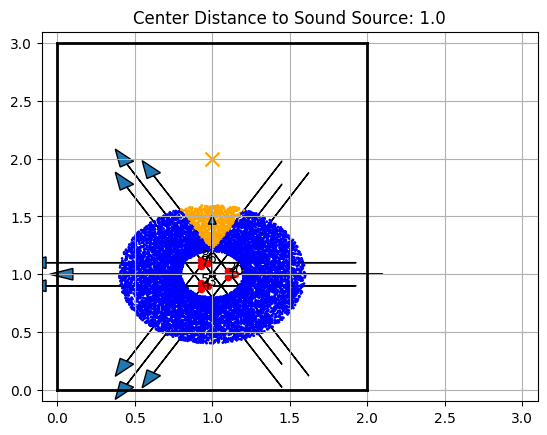

False

In [578]:
#robots = ePuck(init_center=np.array([1., 1.]), microphone_distance=0.1)
robots = TriangleTeam(init_center=np.array([1., 1.]), ep_microphone_distance=0.05)
run_sim_step(robots)

Convergence


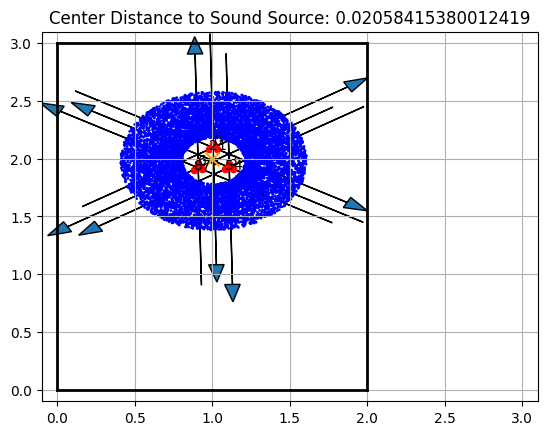

True

In [583]:
run_sim_step(robots)
#robots.current_center

In [721]:
def plot_formation_state(epuck_centers, desired_positions):

    plt.scatter(desired_positions[:, 0], 
                desired_positions[:, 1], 
                s=[100 for i in range(desired_positions.shape[0])], 
                c="green")
    
    
    plt.scatter(epuck_centers[:, 0], 
                epuck_centers[:, 1], 
                s=[10 for i in range(epuck_centers.shape[0])], 
                c="red")
    
    for microphones in [epuck_centers, desired_positions]:
        for i in range(3):
            plt.text(microphones[i, 0],
                    microphones[i, 1], str(i))
    
    plt.show()

def distance_comparison_plot(distances, noise_levels):

    colors = ["blue", "red", "orange", "green", "yellow", "violet"]

    i = 0
    for distance_log, noise_level in zip(distances, noise_levels):

        plt.plot([k for k in range(len(distance_log))], distance_log, label=str(noise_level), color=colors[i % len(colors)])
        i += 1
    
    plt.xticks([k for k in range(len(distances[0]))])
    
    plt.title("Comparison of cumulative distances to gt for different noise levels")
    plt.legend()
    plt.show()



In [722]:
def move_close_to_center(epucks, desired_robot_distance, noisy, sigma):

    for i in range(3):
        
        target_puck = epucks[(i + 1) % 3]
        current_puck = epucks[i]

        target_point = target_puck.current_center
        current_diff = np.linalg.norm(target_puck.current_center - current_puck.current_center)
        move_length = current_diff - desired_robot_distance

        if noisy:
            target_point = np.array([np.random.normal(target_point[0], sigma),
                                     np.random.normal(target_point[1], sigma)])
            move_length = np.random.normal(move_length, sigma)
            
        diff_vec = target_point - current_puck.current_center
        current_puck.current_center += (diff_vec/np.linalg.norm(diff_vec)) * move_length




In [723]:
def cumulative_distance(gt_positions, acting_positions):
    return np.sum(np.linalg.norm(gt_positions-acting_positions, axis=0))


def formation_test(n_steps=100, noisy=False, sigma=0.01, do_plot_formation_state=True):

    acting_robot_team = TriangleTeam(init_center=np.array([1., 1.]), robot_distance=0.2)
    gt_robot_team = TriangleTeam(init_center=np.array([1., 1.]), robot_distance=0.2)

    #desired_pos = acting_robot_team.get_triangle_positions(acting_robot_team.robot_distance)
    #normalized_desired_pos = desired_pos - np.average(desired_pos, axis=0)
    # Apply Noise
    for epuck in acting_robot_team.epucks:
        epuck.current_center += 0.1 * 2*(np.random.rand()-1)

    
    distances = []

    for _ in range(n_steps):

        epuck_centers = np.concatenate((acting_robot_team.epucks[0].current_center.reshape(1, 2),
                                        acting_robot_team.epucks[1].current_center.reshape(1, 2),
                                        acting_robot_team.epucks[2].current_center.reshape(1, 2)), axis=0)
        
        acting_center = np.average(epuck_centers, axis=0)
        zero_micro_loc = acting_robot_team.epucks[0].current_center

        gt_robot_team.current_center = acting_center
        gt_robot_team.current_ori = math.atan2(zero_micro_loc[1] - acting_center[1],
                                               zero_micro_loc[0] - acting_center[0])
        desired_position = gt_robot_team.get_triangle_positions(gt_robot_team.robot_distance)

        distances.append(cumulative_distance(desired_position, epuck_centers))

        if do_plot_formation_state:
            plot_formation_state(epuck_centers, desired_position)

        move_close_to_center(acting_robot_team.epucks, acting_robot_team.robot_distance, noisy, sigma)
        #robot_team.move(1, 0)

    return distances
        

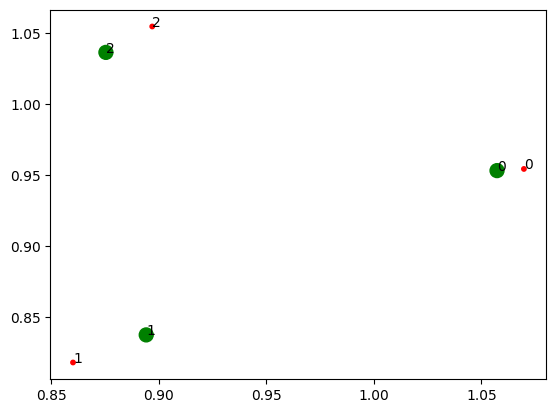

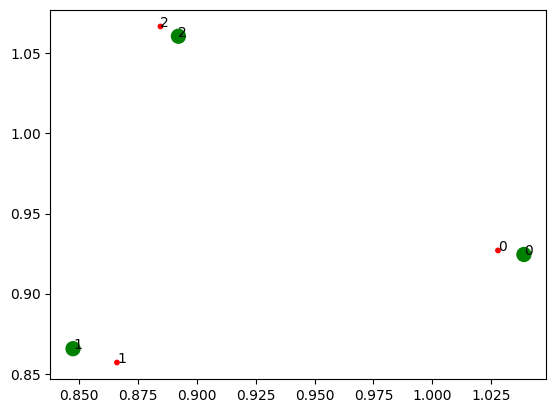

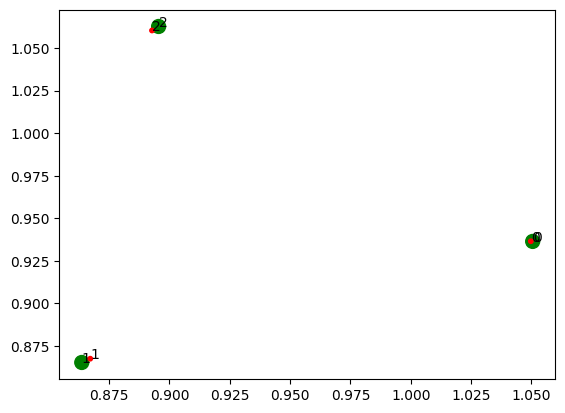

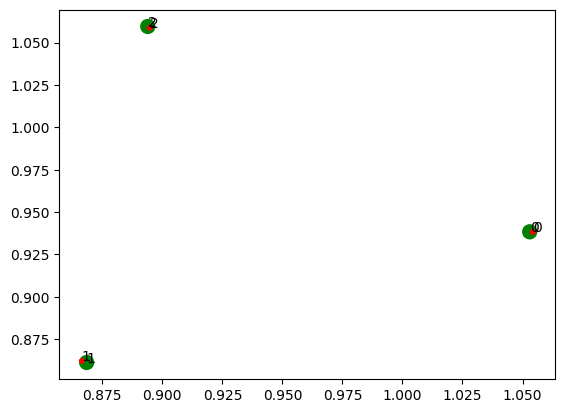

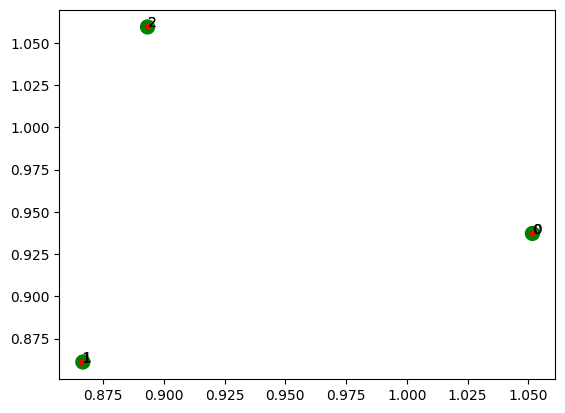

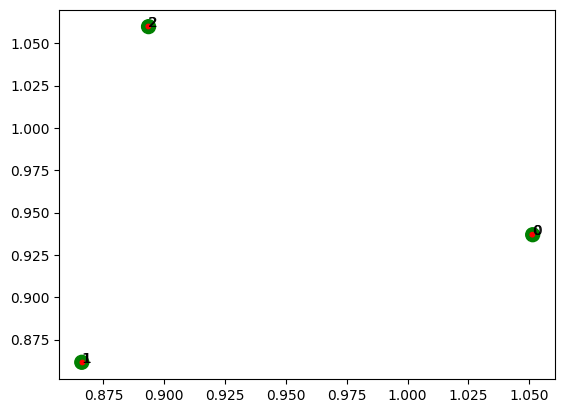

[np.float64(0.06886473784159855),
 np.float64(0.0337667921492818),
 np.float64(0.007767791127161139),
 np.float64(0.003675481509605617),
 np.float64(0.0009731258012378688),
 np.float64(0.0004651233230730911)]

In [724]:
formation_test(6, False)

In [725]:
def compare_noisy_formation_restoration():

    sigmas = [0., 0.01, 0.03, 0.05, 0.1]
    dists = []

    for sigma in sigmas:

        noisy = True
        if sigma == 0:
            noisy = False
        
        dist_log = formation_test(20, noisy, sigma, False)
        dists.append(dist_log)
    
    distance_comparison_plot(dists, sigmas)
    

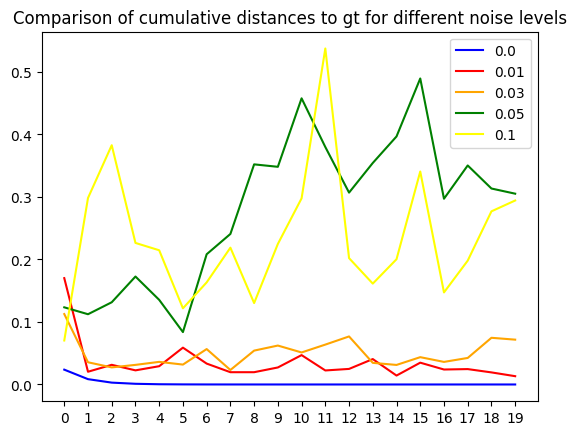

In [726]:
compare_noisy_formation_restoration()